In [1]:
from docx2python import docx2python
import numpy as np
import os
import json
import pandas as pd
import pickle
import time
#import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from scipy import stats

#df, data frame of "sweunions.json"
#em, pre-trained embedding dictionary, 2,000,000 * 300

Trade Unions (2010-2020, förbundspress):
    * A, LO centralt
    * HR, Hotell- o resturangfacket;
    * H, Handelsanställdas förbund
    * L, Livsmedelsarbetarförbundet
    * K, Kommunalarbetarförbundet
    * DA,IF Metall
    * FF,Fastighetsansälldas förbund
    * BA,Byggnadsarbetarförbundet
    * E, Elektrikerförbundet
    * M, Målarna
    * S, Seko
    * T, Transportarbetarförbundet

### 1. Data Preparation

#### Load Session/States

In [2]:
vocab_df1=pickle.load(open( "./States/code1_vocab_df1.p", "rb" ) ) ## load state for local words in df1 12633 words, exclusive 'unk'

#sen=[tokenizer(s) for s in df1['sentence']]
#pickle.dump(sen, open( ("./States/code3_sen.p"), "wb" ) ) ## save input sentences 
sen=pickle.load(open( ("./States/code3_sen.p"), "rb" ))

In [3]:
#len(vocab_df1)
'unk' in vocab_common

False

#### Read press conference documents

In [4]:
with open('sweunions_sentences.json','r',encoding='utf-8') as source: #C:/Users/A550240/Desktop/LIU/3.2_TextMining/Project/1.SelectedData/
    df1 = pd.read_json(source) ## each sentence

In [6]:
df1.head() ## 15395*4

,union,year,title,sentence
0,LO centralt,2010,Arbetare utnyttjas,Arbetare utnyttjas grovt Arbetare utnyttjas g...
1,LO centralt,2010,Arbetare utnyttjas,Den bedömningen gör professor Gregor Noll på ...
2,LO centralt,2010,Arbetare utnyttjas,Han ser två tunga orsaker till att papperslös...
3,LO centralt,2010,Arbetare utnyttjas,– Det ena är att vi allt mer konkurrerar med ...
4,LO centralt,2010,Arbetare utnyttjas,"Det andra skälet är, enligt Gregor Noll, att ..."


#### Tokenizer and POSer

In [7]:
import stanza

#stanza.download('sv')

In [8]:
nlp=stanza.Pipeline(lang='sv',processors='tokenize,lemma,pos')

2021-03-08 20:35:23 INFO: Loading these models for language: sv (Swedish):
| Processor | Package   |
-------------------------
| tokenize  | talbanken |
| pos       | talbanken |
| lemma     | talbanken |

2021-03-08 20:35:23 INFO: Use device: cpu
2021-03-08 20:35:23 INFO: Loading: tokenize
2021-03-08 20:35:23 INFO: Loading: pos
2021-03-08 20:35:24 INFO: Loading: lemma
2021-03-08 20:35:24 INFO: Done loading processors!


In [9]:
## Tokenizer
def preprocess(doc):
    tok=nlp(doc)
    re1=[]
    re2=[]
    stop=['.',':',',','i','att','med','på','en','ett','till','och','-','–','den',
          'vara','av','som','men','till','denna','för','in','(',')','eller',
          'sån','sedan','•','?','om','!','%','&','--','\'','*','**','"','”','“','[avläsT',
          '[',']','/','»','«',';','=','+',
          '[accessed','[aläst','[avläst','[online]','[sg_popup','[ur', '[vläst',
          '‚ä®sverige', '…','‰r','″', '→', '●', '\uf0b7']
    za1=['"','(',')','“','”','*',':',',','.']
    for sentence in tok.sentences:
        for word in sentence.words:
            #print(word.lemma)
            if word.text in stop or word.text.isnumeric(): ## remove stop words and numbers
                pass            
            elif len(set(list('0123456789')).intersection(set(list(word.text))))>0: 
                pass            
            elif word.text not in za1 and len(set(za1).intersection(set(list(word.text))))>0:
                tem=str(word.text)
                for za in za1:
                    if tem.__contains__(za):
                        #print(tem)
                        ha=list(tem)
                        ha.remove(za)
                        tem=''.join(ha)
                #print(tem)
                if len(tem)>0:
                    f=[e.words for e in nlp(tem).sentences]
                    if len(f)>0:
                        re1.append(f[0][0].lemma)
                        re2.append(f[0][0].pos)
            elif word.text.endswith('-') or word.text.startswith('-') and word.text!='-' and word.text!='--':
                #print(word.text)
                mu=word.text.replace('-','')
                if len(mu)>0:  ## modified when building em_common_sum
                    f=[e.words for e in nlp(mu).sentences]     
                    re1.append(f[0][0].lemma)
                    re2.append(f[0][0].pos)
            else:
                re1.append(word.lemma)
                re2.append(word.pos)

        
    return re1,re2

def tokenizer(doc):
    re,_=preprocess(doc)
    return re

def pos(doc):
    _,re=preprocess(doc)
    return re

## tokenizer('jag var ingejörer')
## ['jag', 'vara', 'ingejör']
## tokenizer(df['press'][6])

#t=tokenizer(df['press'][368])  ## tokenizer
#p=pos(df['press'][368])  ## get POS 

In [10]:
tokenizer(df1['sentence'][6])

['denna',
 'eftersom',
 'vissa',
 'stanna',
 'kvar',
 'efter',
 'arbetstillstånd',
 'löpa',
 'ut']

### 2. Embeddings training

In [302]:
def dis(weight,vec,word):  ##  L2 norm distance between word a and b
    return np.sqrt(np.sum(np.square(vec-weight[word])))

def avg(weight,group,size):  ## calculate average vectors for word groups
    re=np.array(np.zeros(size))
    n=0
    for word in group:
        if word in weight.vocab:
            n+=1
            re+=weight[word]
    return re/n

def rnd(weight,nwords,swords,iwords,size):  ## relative norm distance
    svec=avg(weight,swords,size)
    ivec=avg(weight,iwords,size)
    re=0
    n=0
    for word in nwords:
        if word in weight.vocab:
            n+=1
            re+=dis(weight,svec,word)-dis(weight,ivec,word) ##  dis(swords)-dis(iwords)
    return re/n

In [347]:
def train(par,li,sentences,niter,window,min_count,size,sg,hs,workers,nwords,swords,iwords):    
    for ele in li:
        print(par,':',ele)

        if par=='year':
            ind=[i for i,e in enumerate(df1[par]) if e in [ele-1,ele,ele+1]]  ## filter index   
        if par=='union':
            ind=[i for i,e in enumerate(df1[par]) if e==ele]  ## filter index    

        em=[]
        for i in range(niter):
            ## construct model
            model= Word2Vec(sentences=list(np.array(sentences)[ind]),window=window,min_count=min_count,size=size,sg=sg,hs=hs,workers=workers)
            em.append(rnd(model.wv,nwords,swords,iwords,size))
            
            if(not (i+1)%50): 
                print(i+1,"/",niter,"done")
        
        pickle.dump(em, open( ("./States/code3_em_"+str(ele)+".p"), "wb" ) ) ## save weights 
               
    print("ALL DONE!")  

In [344]:
nwords=['arbetsmarknad','jobb','chans','tjänst','yrke',
        'arbetsförmedling','arbetstagare','lön','intervju','anställning']  ## neutral words 10
swords=['svensk','medborgare','inrikes','Tomas','Björn',
        'Lena','anna','Stefan','Karin','Sara',
        'Malin','Andreas','Jan','Johansson','Maria',
        'Erik','Sven','Peter','Carl','Mikael',
        'Elisabeth','Eva','Kristina','Birgitta']  ## svensk group 25
iwords=['invandrare','flykting','migration','visum',
        'asyl','utomlands','arbetstillstånd','migrationsverket','asylsökande',
        'arbetskraftsinvandring','nyanlända']  ## immigrants group 10

#### Train by years

In [317]:
years=[e+2011 for e in list(range(9))]   ### year 2011-2019
train(par='year',li=years,sentences=sen,niter=100,window=5,min_count=5,size=100,sg=0,hs=1,workers=4,nwords=nwords,swords=swords,iwords=iwords)

year : 2011
50 / 100 done
100 / 100 done
year : 2012
50 / 100 done
100 / 100 done
year : 2013
50 / 100 done
100 / 100 done
year : 2014
50 / 100 done
100 / 100 done
year : 2015
50 / 100 done
100 / 100 done
year : 2016
50 / 100 done
100 / 100 done
year : 2017
50 / 100 done
100 / 100 done
year : 2018
50 / 100 done
100 / 100 done
year : 2019
50 / 100 done
100 / 100 done
ALL DONE!


#### Train by unions

In [349]:
unions=list(set(list(df1['union'])))   ##  all unions
train(par='union',li=unions,sentences=sen,niter=100,window=5,min_count=5,size=100,sg=0,hs=1,workers=4,nwords=nwords,swords=swords,iwords=iwords)

union : Livsmedelsarbetarförbundet
50 / 100 done
100 / 100 done
union : Elektrikerförbundet
50 / 100 done
100 / 100 done
union : Hotell- o resturangfacket
50 / 100 done
100 / 100 done
union : Kommunalarbetarförbundet
50 / 100 done
100 / 100 done
union : Transportarbetarförbundet
50 / 100 done
100 / 100 done
union : Målarna
50 / 100 done
100 / 100 done
union : IF Metall
50 / 100 done
100 / 100 done
union : Handelsanställdas förbund
50 / 100 done
100 / 100 done
union : Byggnadsarbetarförbundet
50 / 100 done
100 / 100 done
union : Fastighetsansälldas förbund
50 / 100 done
100 / 100 done
union : Seko
50 / 100 done
100 / 100 done
union : LO centralt
50 / 100 done
100 / 100 done
ALL DONE!


### 3. Analysis

In [305]:
from scipy import stats

def ttest(a,b,alpha): ## test if rv A and B have significantly different mean 
    mu1=np.mean(a)
    mu2=np.mean(b)
    n1=len(a)
    n2=len(b)
    s1=np.var(a)
    s2=np.var(b)
    t=(mu1-mu2)/((  ((n1-1)*s1+(n2-1)*s2)/(n1+n2-2)  )*np.sqrt(1/n1+1/n2))
    if(np.abs(t)<abs(stats.t(df=(n1+n2-2)).ppf(1-0.5*alpha))):
        print("Embeddings for "+str(a)+" and "+str(b)+" are not significantly different")
    return 1-np.abs(stats.t.cdf(t,(n1+n2-2))-0.5)*2

#### By years

In [318]:
em_2011=pickle.load(open( ("./States/code3_em_2011.p"), "rb" ) )
em_2012=pickle.load(open( ("./States/code3_em_2012.p"), "rb" ) )
em_2013=pickle.load(open( ("./States/code3_em_2013.p"), "rb" ) )
em_2014=pickle.load(open( ("./States/code3_em_2014.p"), "rb" ) )
em_2015=pickle.load(open( ("./States/code3_em_2015.p"), "rb" ) )
em_2016=pickle.load(open( ("./States/code3_em_2016.p"), "rb" ) )
em_2017=pickle.load(open( ("./States/code3_em_2017.p"), "rb" ) )
em_2018=pickle.load(open( ("./States/code3_em_2018.p"), "rb" ) )
em_2019=pickle.load(open( ("./States/code3_em_2019.p"), "rb" ) )

In [319]:
years=[e+2011 for e in list(range(9))]  
rnd_years_mean=[]
rnd_years_up=[]
rnd_years_low=[]
t_ma_years=np.zeros((9,9))
alpha=0.05

for i,e in enumerate(years):
    rnd_years_mean.append(np.mean(eval('em_'+str(years[i]))))
    rnd_years_up.append(np.quantile(eval('em_'+str(years[i])),1-alpha,interpolation='lower'))
    rnd_years_low.append(np.quantile(eval('em_'+str(years[i])),alpha,interpolation='higher'))
    for j in list(range(len(years)))[i+1:]:
        t_ma_years[i,j]=ttest(eval('em_'+str(years[i])),eval('em_'+str(years[j])),alpha)
    
rnd_years_mean=list(np.array(rnd_years_mean).flatten())
rnd_years_up=list(np.array(rnd_years_up).flatten())
rnd_years_low=list(np.array(rnd_years_low).flatten())
t_ma_years

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

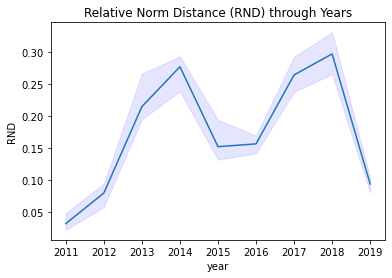

In [320]:
fig, ax = plt.subplots();
ax.plot(years,rnd_years_mean);
ax.fill_between(years, rnd_years_low, rnd_years_up, color='b', alpha=.1);
ax.set_title('Relative Norm Distance (RND) through Years');
ax.set_xlabel('year');
ax.set_ylabel('RND');

In [322]:
rnd_years_mean

[0.03254769227474995,
 0.0800989530890483,
 0.21468565077420543,
 0.27675357138454276,
 0.15233670860752094,
 0.15665975883650135,
 0.26411073341070906,
 0.29677222808006193,
 0.09427296334942517]

#### By unions

Trade Unions (2010-2020, förbundspress):
    * A, LO centralt
    * HR, Hotell- o resturangfacket;
    * H, Handelsanställdas förbund
    * L, Livsmedelsarbetarförbundet
    * K, Kommunalarbetarförbundet
    * DA,IF Metall
    * FF,Fastighetsansälldas förbund
    * BA,Byggnadsarbetarförbundet
    * E, Elektrikerförbundet
    * M, Målarna
    * S, Seko
    * T, Transportarbetarförbundet

In [350]:
em_A=pickle.load(open( ("./States/code3_em_LO centralt.p"), "rb" ) )
em_S=pickle.load(open( ("./States/code3_em_Seko.p"), "rb" ) )
em_DA=pickle.load(open( ("./States/code3_em_IF Metall.p"), "rb" ) )
em_T=pickle.load(open( ("./States/code3_em_Transportarbetarförbundet.p"), "rb" ) )
em_FF=pickle.load(open( ("./States/code3_em_Fastighetsansälldas förbund.p"), "rb" ) )
em_HR=pickle.load(open( ("./States/code3_em_Hotell- o resturangfacket.p"), "rb" ) )
em_K=pickle.load(open( ("./States/code3_em_Kommunalarbetarförbundet.p"), "rb" ) )
em_L=pickle.load(open( ("./States/code3_em_Livsmedelsarbetarförbundet.p"), "rb" ) )
em_H=pickle.load(open( ("./States/code3_em_Handelsanställdas förbund.p"), "rb" ) )
em_BA=pickle.load(open( ("./States/code3_em_Byggnadsarbetarförbundet.p"), "rb" ) )
em_E=pickle.load(open( ("./States/code3_em_Elektrikerförbundet.p"), "rb" ) )
em_M=pickle.load(open( ("./States/code3_em_Målarna.p"), "rb" ) )

In [351]:
unions=['A','S','DA','T','FF','HR','K','L','H','BA','E','M']
rnd_unions_mean=[]
rnd_unions_up=[]
rnd_unions_low=[]
t_ma_unions=np.zeros((12,12))
alpha=0.05

for i,e in enumerate(unions):
    rnd_unions_mean.append(np.mean(eval('em_'+str(unions[i]))))
    rnd_unions_up.append(np.quantile(eval('em_'+str(unions[i])),1-alpha,interpolation='lower'))
    rnd_unions_low.append(np.quantile(eval('em_'+str(unions[i])),alpha,interpolation='higher'))
    for j in list(range(len(unions)))[i+1:]:
        t_ma_unions[i,j]=ttest(eval('em_'+str(unions[i])),eval('em_'+str(unions[j])),alpha)
    
rnd_unions_mean=list(np.array(rnd_unions_mean).flatten())
rnd_unions_up=list(np.array(rnd_unions_up).flatten())
rnd_unions_low=list(np.array(rnd_unions_low).flatten())
t_ma_unions

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

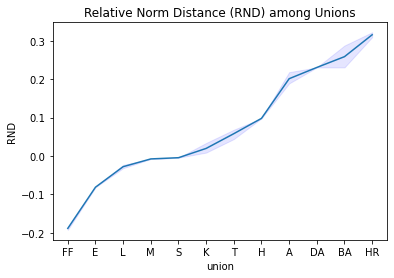

In [360]:
ind=list(np.argsort(rnd_unions_mean))

fig, ax = plt.subplots();
ax.plot(list(np.array(unions)[ind]),list(np.array(rnd_unions_mean)[ind]));
ax.fill_between(list(np.array(unions)[ind]), list(np.array(rnd_unions_low)[ind]), list(np.array(rnd_unions_up)[ind]), color='b', alpha=.1);
ax.set_title('Relative Norm Distance (RND) among Unions');
ax.set_xlabel('union');
ax.set_ylabel('RND');

In [353]:
rnd_unions_mean

[0.20104387687690642,
 -0.004621612867342382,
 0.23035366344154792,
 0.05791799863630575,
 -0.18862152198848725,
 0.3154094925854526,
 0.019559513855637263,
 -0.02800947862823533,
 0.09778005588238103,
 0.2584316242935976,
 -0.08144926603208448,
 -0.007787334397872995]